In [ ]:
from google.colab import files

!pip install kaggle

uploaded = files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle competitions download -c house-prices-advanced-regression-techniques

house-prices-advanced-regression-techniques.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip "/content/house-prices-advanced-regression-techniques.zip" -d "/content/house-prices-advanced-regression-techniques"

Archive:  /content/house-prices-advanced-regression-techniques.zip
replace /content/house-prices-advanced-regression-techniques/data_description.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
import pandas as pd
import warnings

warnings.filterwarnings("ignore")

In [ ]:
train_data = pd.read_csv('/content/house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('/content/house-prices-advanced-regression-techniques/test.csv')

train_data = train_data.drop('Id', axis = 1)
test_data = test_data.drop('Id', axis = 1 )

n_train = train_data.shape[0]

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

In [ ]:
train_data['Neighborhood']

0       CollgCr
1       Veenker
2       CollgCr
3       Crawfor
4       NoRidge
         ...   
1455    Gilbert
1456     NWAmes
1457    Crawfor
1458      NAmes
1459    Edwards
Name: Neighborhood, Length: 1460, dtype: object

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# **Data Preprocessing**

In [ ]:
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import mutual_info_regression
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer

from scipy.stats import skew, norm, boxcox,yeojohnson

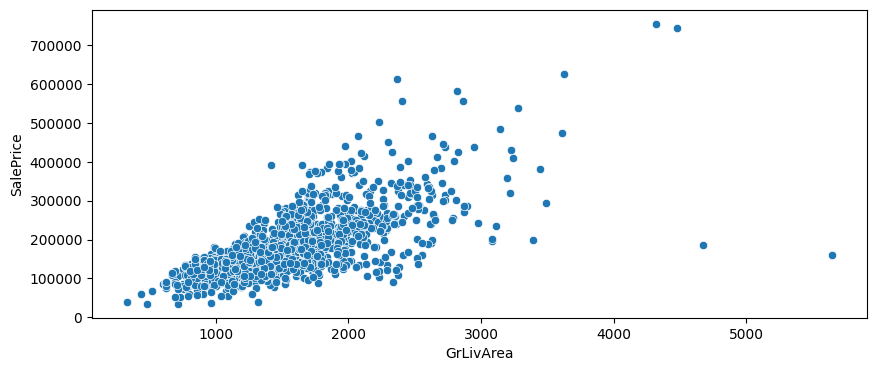

In [ ]:
plt.figure(figsize = (10,4))
sns.scatterplot(x = train_data['GrLivArea'], y = train_data['SalePrice'])
plt.show()

<Axes: xlabel='SalePrice', ylabel='Density'>

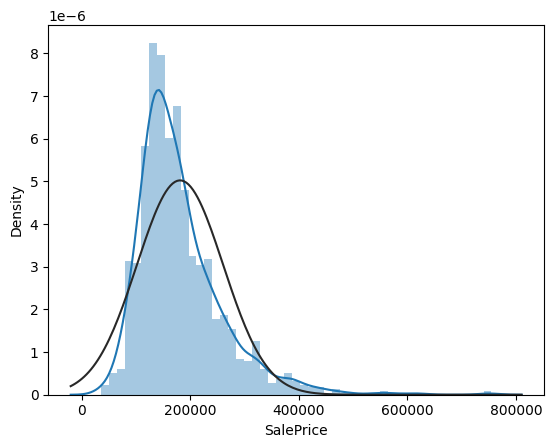

In [ ]:
sns.distplot(train_data['SalePrice'], fit = norm)

<Axes: xlabel='SalePrice', ylabel='Density'>

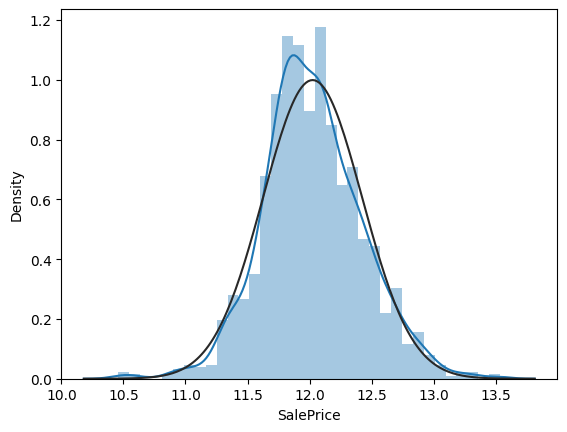

In [ ]:
train_data['SalePrice'] = np.log(train_data['SalePrice'])
sns.distplot(train_data['SalePrice'], fit = norm)

In [ ]:
combined_data = pd.concat([train_data, test_data])
combined_data.drop(['SalePrice'], axis = 1, inplace = True)

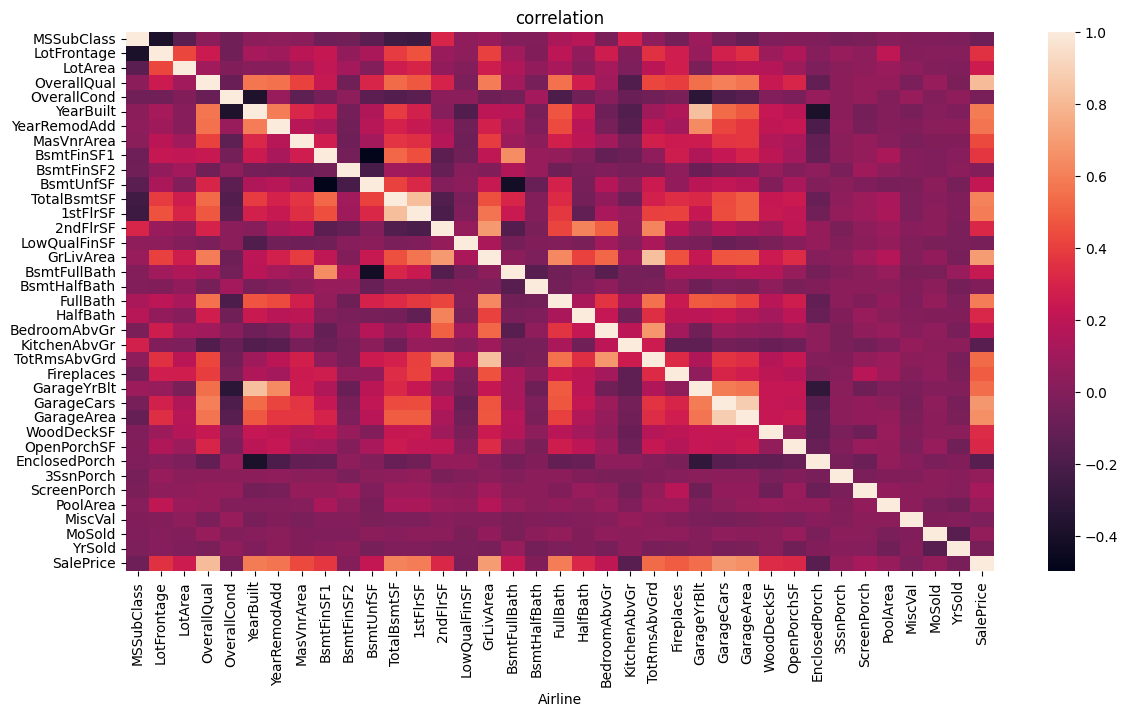

In [ ]:
plt.figure(figsize=(14, 7))
plt.title("correlation")
corr_matrix = train_data.corr()
# Plotting the heatmap for the top k correlations
sns.heatmap(corr_matrix)
# Add label for horizontal axis
plt.xlabel("Airline")
plt.show()

**Feature Engineering**

In [ ]:
combined_data['AgeAtSale'] = (combined_data['YearBuilt'] - combined_data['YrSold']) - (combined_data['YearRemodAdd'] - combined_data['YrSold'])
combined_data['TotalFloorSF'] = combined_data['TotalBsmtSF'] + combined_data['1stFlrSF'] + combined_data['2ndFlrSF']

In [ ]:
numeric_data = combined_data.select_dtypes(exclude = 'object')
categorical_data = combined_data.select_dtypes(include = 'object')

numeric_features = [col for col in numeric_data.columns]
categorical_features = [col for col in categorical_data.columns]

In [ ]:
train_set = combined_data[:n_train]
test_set = combined_data[n_train:]

**Handle Missing Value**


In [ ]:
def display_missing_value(data):
  missing_data = [col for col in data.columns
                  if data[col].isnull().any()]  #เพิ่มcolumn name เข้าใน missing data ถ้าใน column นั้นมีอย่างน้อย 1 ตัวที่เป็น missing value
  count_missing = data[missing_data].isnull().sum() #นับว่าในแต่ละcolumn มี missing value มากแค่ไหน
  count_missing = count_missing.sort_values(ascending = False) #นำค่าที่นับได้มาเรียงจากมากไปน้อย
  return count_missing

In [ ]:
display_missing_value(combined_data).head()

PoolQC         2909
MiscFeature    2814
Alley          2721
Fence          2348
FireplaceQu    1420
dtype: int64

In [ ]:
missing_house_data = [col for col in combined_data.columns
                  if combined_data[col].isnull().any()] #เพิ่มcolumn name เข้าใน missing house data ถ้าใน column นั้นมีอย่างน้อย 1 ตัวที่เป็น missing value
missing_data = combined_data[missing_house_data] #เลือกเอา data เฉพาะ column ที่มี missing value
cat_missing_data = missing_data.select_dtypes(include = 'object') #เลือกเฉพาะ column ที่มี dtype เป็น object
num_missing_data = missing_data.select_dtypes(exclude = 'object') #เลือกเฉพาะ column ที่มี dtype ไม่เป็น object

cat_missing_cols = [col for col in cat_missing_data.columns] #เอาชื่อ column มาใส่
num_missing_cols = [col for col in num_missing_data.columns]
print(cat_missing_cols)
print(num_missing_cols)

['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence', 'MiscFeature', 'SaleType']
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'TotalFloorSF']


In [ ]:
from sklearn.impute import SimpleImputer

# Create SimpleImputer instances with specific strategies
cat_imputer = SimpleImputer(strategy='constant', fill_value='None')
num_imputer = SimpleImputer(strategy='constant', fill_value=0)

# Fit and transform the training set
train_set[cat_missing_cols] = cat_imputer.fit_transform(train_set[cat_missing_cols])
train_set["LotFrontage"] = train_set.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
train_set[num_missing_cols] = num_imputer.fit_transform(train_set[num_missing_cols])

# Transform the test set using the parameters learned from the training set
test_set[cat_missing_cols] = cat_imputer.transform(test_set[cat_missing_cols])
test_set["LotFrontage"] = test_set.groupby("Neighborhood")["LotFrontage"].transform(
    lambda x: x.fillna(x.median()))
test_set[num_missing_cols] = num_imputer.transform(test_set[num_missing_cols])

In [ ]:
display_missing_value(test_set)

Series([], dtype: float64)

In [ ]:
display_missing_value(train_set)

Series([], dtype: float64)

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks, fontsize = 12)
    plt.xticks(fontsize = 12)
    plt.title("Mutual Information Scores", fontsize = 16)

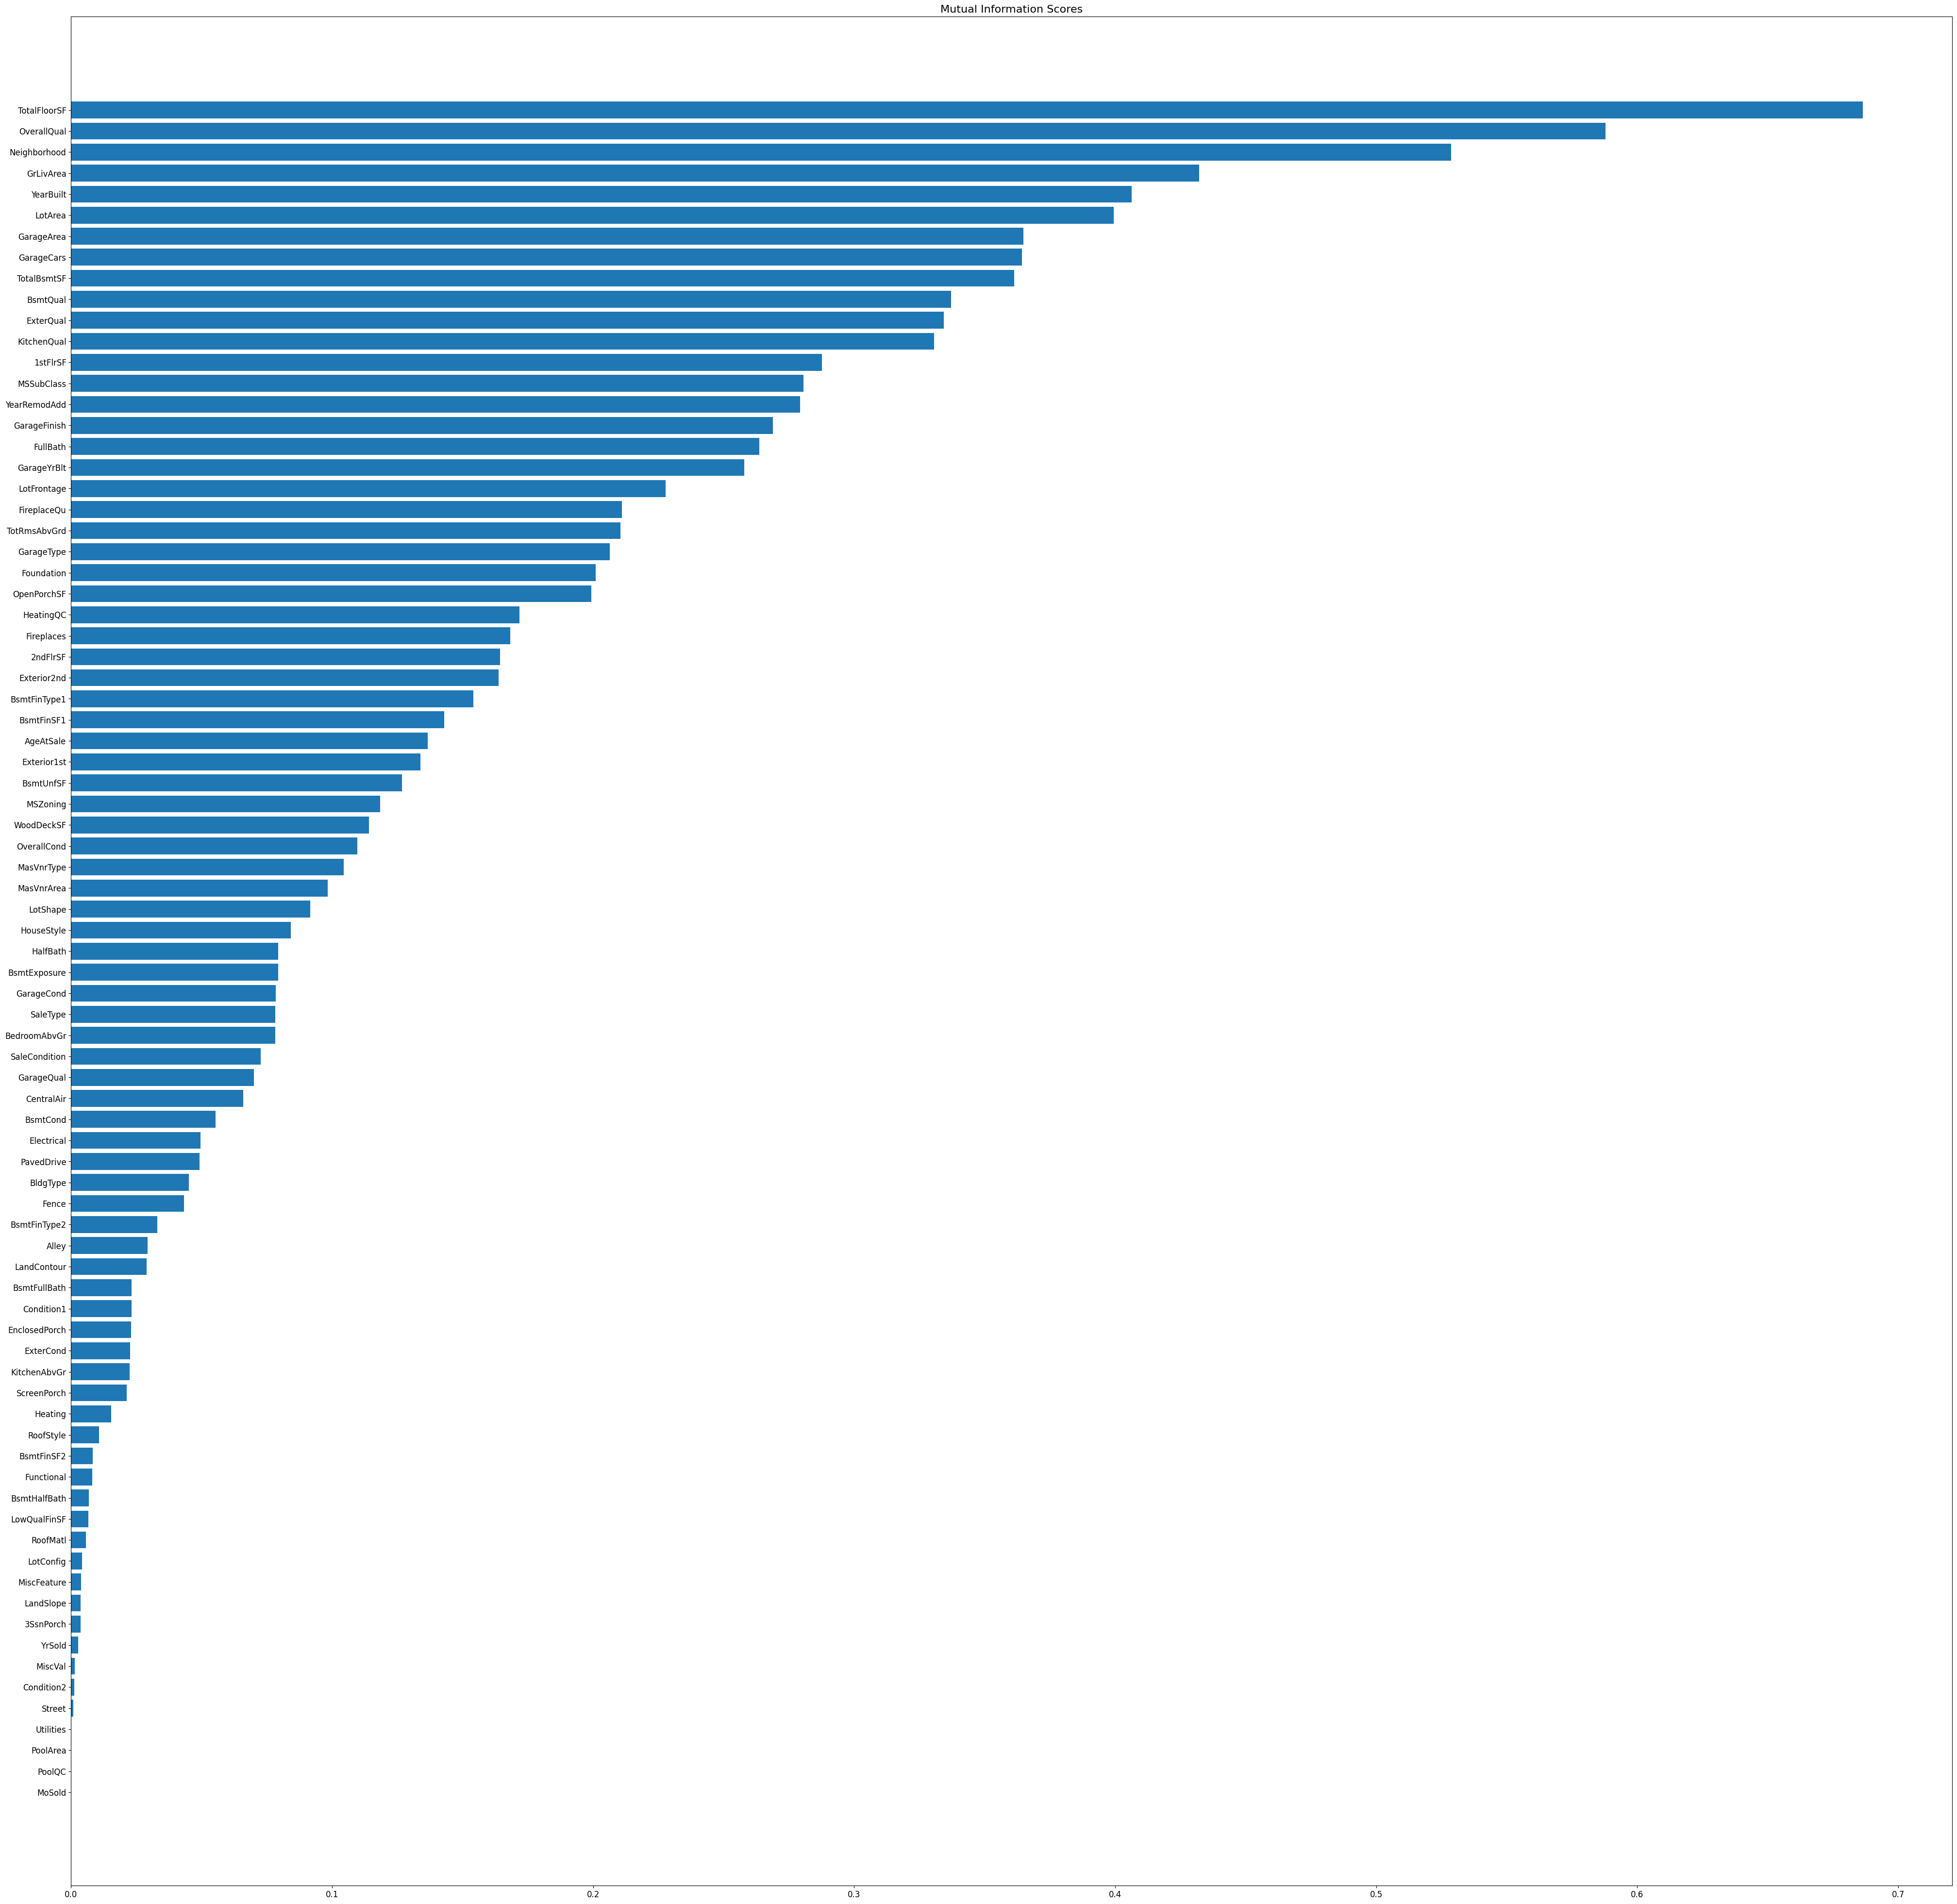

In [ ]:
mi_X = train_set.copy()
mi_y = train_data.copy().SalePrice
for col in mi_X.select_dtypes('object'):
  mi_X[col], _ = mi_X[col].factorize()

discrete_features = mi_X.dtypes == int

scores = make_mi_scores(mi_X, mi_y, discrete_features = discrete_features)
plt.figure(figsize = (50,50))
plot_mi_scores(scores)

In [ ]:
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [ ]:
def show_skewness(data):
    # Select numeric columns
    num_col = data.select_dtypes(exclude='object')
    num_feats = [feat for feat in num_col.columns]

    # Calculate skewness for each numeric feature
    skewed_feats = data[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew': skewed_feats})

    return skewness

# Example Usage:
# Assuming 'your_data' is your DataFrame
skewness_result = show_skewness(train_data)
skewness_result

,Skew
MiscVal,24.451640
PoolArea,14.813135
LotArea,12.195142
3SsnPorch,10.293752
LowQualFinSF,9.002080
KitchenAbvGr,4.483784
BsmtFinSF2,4.250888
ScreenPorch,4.117977
BsmtHalfBath,4.099186
EnclosedPorch,3.086696


In [ ]:
def handle_skewness(train_data,test_data=None, skew_threshold=0.75):
    # Select numeric columns
    num_col = train_data.select_dtypes(exclude='object')
    num_feats = [feat for feat in num_col.columns]

    # Calculate skewness for each numeric feature
    skewed_feats = train_data[num_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
    skewness = pd.DataFrame({'Skew': skewed_feats})

    # Identify features with absolute skewness greater than the threshold
    high_skew_features = skewness[abs(skewness.values) > skew_threshold].index

    # Apply PowerTransformer to handle skewness
    transformer = PowerTransformer(method='yeo-johnson', standardize=False)
    train_data[high_skew_features] = transformer.fit_transform(train_data[high_skew_features])

    if test_data is not None:
      test_data[high_skew_features] = transformer.transform(test_data[high_skew_features])

    return train_data, test_data

In [ ]:
train_trans, test_trans = handle_skewness(train_set, test_set)

In [ ]:
after_transform = show_skewness(train_trans)
after_transform

,Skew
PoolArea,14.337930
3SsnPorch,7.605922
LowQualFinSF,7.291912
MiscVal,5.011373
BsmtHalfBath,3.855436
ScreenPorch,3.110067
BsmtFinSF2,2.423157
EnclosedPorch,2.045836
OverallCond,0.692355
TotRmsAbvGrd,0.675646


In [ ]:
all_data = pd.concat([train_trans, test_trans], axis = 0)

In [ ]:
all_data = pd.get_dummies(all_data, dtype = int)
train_data_set = all_data[:n_train]
test_data_set = all_data[n_train:]

In [ ]:
train_data_set.info

<bound method DataFrame.info of       MSSubClass  LotFrontage    LotArea  OverallQual  OverallCond  YearBuilt  \
0       2.661928    12.552990  10.427531            7            5       2003   
1       2.191299    13.990554  10.596445            6            8       1976   
2       2.661928    12.853767  10.807340            7            5       2001   
3       2.720051    12.034615  10.589519            7            5       1915   
4       2.661928    14.348787  11.124530            8            5       2000   
...          ...          ...        ...          ...          ...        ...   
1455    2.661928    12.244651  10.341536            6            5       1999   
1456    2.191299    14.436899  11.018398            6            6       1978   
1457    2.720051    12.654063  10.517089            7            9       1941   
1458    2.191299    12.853767  10.612516            5            6       1950   
1459    2.191299    13.528895  10.642234            5            6       1965

# **Model Implementation**

In [ ]:
from sklearn.model_selection import train_test_split, KFold, cross_val_score, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, make_scorer

from scipy.stats import uniform, randint

In [ ]:
X = train_data_set.copy()
y = train_data.SalePrice
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size = 0.8, test_size = 0.2, random_state=42)

**Cross Validation Score**

In [ ]:
def mse_cv(model, num_folds):
    kf = KFold(num_folds, shuffle=True, random_state=42)
    mse= -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf)
    return mse

In [ ]:
def rmse_cv(model, num_folds):
    kf = KFold(num_folds, shuffle=True, random_state=42)
    mse= -cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = kf)
    return np.sqrt(mse)

In [ ]:
def r2_cv(model, num_folds):
    kf = KFold(num_folds, shuffle=True, random_state=42)
    r2_scores = cross_val_score(model, X, y, scoring=make_scorer(r2_score), cv=kf)
    return r2_scores

 **XGBRegressor**


In [ ]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [ ]:
xgb_params = {
    'n_estimators': randint(100, 1000),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100]
}


xgb_randomSearch_model = XGBRegressor()
xgb_randomSearch = RandomizedSearchCV(xgb_randomSearch_model, xgb_params, n_iter=50, cv=5,
                                       scoring='neg_mean_squared_error', random_state=42, refit=True)
xgb_randomSearch.fit(X_train, y_train,
              early_stopping_rounds = 5,
              eval_set=[(X_valid, y_valid)],
              verbose = False)

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb48bf89870>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb48b2450c0>,
                                        'reg_alpha': [0, 1e-05, 0.01, 0.1, 1,
                                                      100],
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bb48bf89510>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
xgb_randomSearch.best_params_

{'colsample_bytree': 0.6523068845866853,
 'learning_rate': 0.03930163420191516,
 'max_depth': 6,
 'n_estimators': 191,
 'reg_alpha': 0.1,
 'subsample': 0.5610191174223894}

In [ ]:
xgb_model = xgb_randomSearch.best_estimator_

In [ ]:
print(r2_cv(xgb_model, 5).mean())

0.8934536448164053


In [ ]:
xgb_predict = xgb_model.predict(train_data_set)

In [ ]:
xgb_predictions = np.exp(xgb_predict)
print(xgb_predictions)

[205398.64 176473.48 218347.33 ... 265649.25 139081.23 150820.02]


In [ ]:
actual_price = np.exp(train_data.SalePrice)

In [ ]:
def plot_predictions(actual_price, original_scale_predictions):
    plt.figure(figsize=(16, 10))

    min_ = min(actual_price.min(), original_scale_predictions.min())
    max_ = max(actual_price.max(), original_scale_predictions.max())

    plt.scatter(actual_price, original_scale_predictions)
    plt.xlim([min_, max_])
    plt.ylim([min_, max_])
    plt.xlabel('Actual')
    plt.ylabel('Predicted')
    plt.plot([min_, max_], [min_, max_], c='k')

    plt.show()

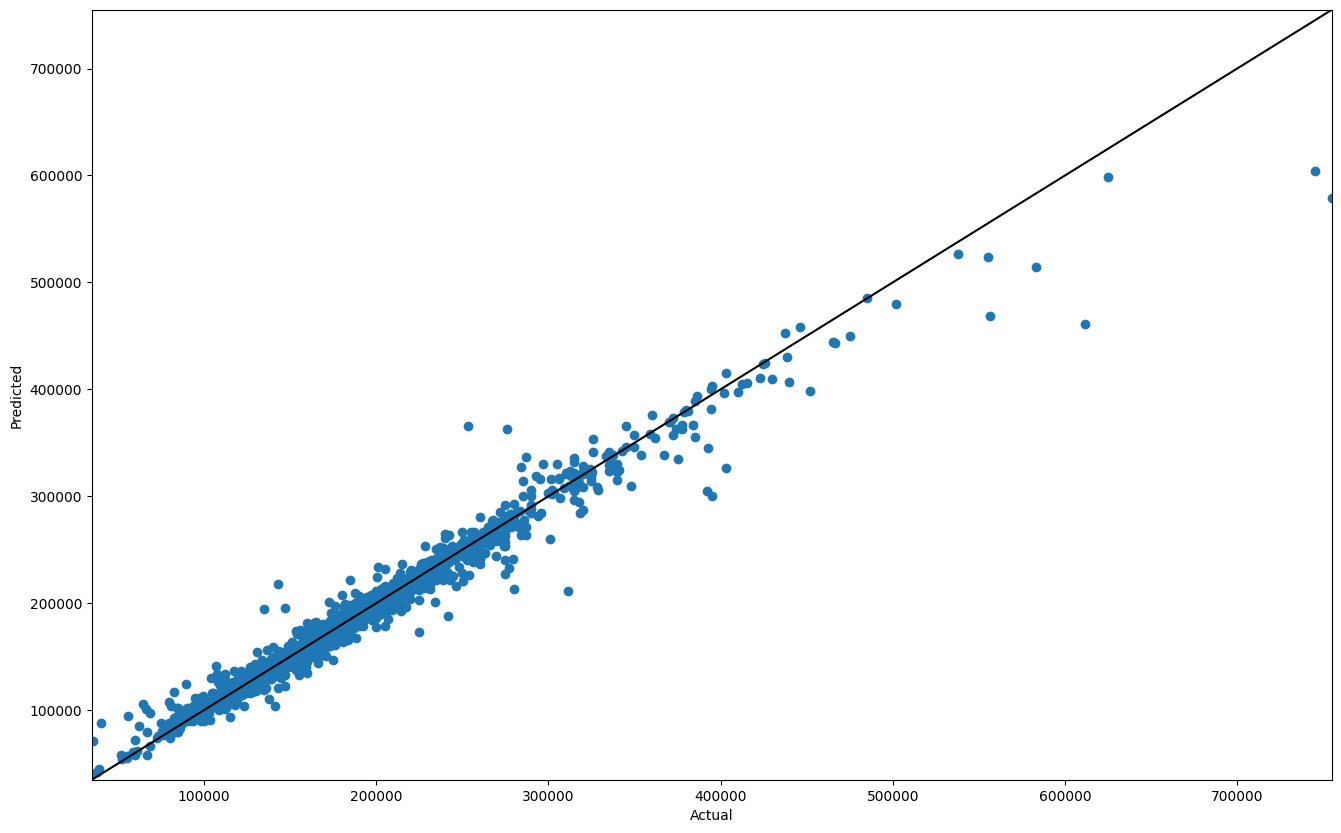

In [ ]:
plot_predictions(actual_price , xgb_predictions)

In [ ]:
xgb_rmse = rmse_cv(xgb_model, 5)

In [ ]:
print(f'root mean squared of xgb_model : {xgb_rmse.mean()}')

root mean squared of xgb_model : 0.12835156760275926


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
gb_params = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.3),
    'max_depth': randint(3, 10),
    'subsample': uniform(0.5, 0.5),
    'min_samples_split': randint(2, 20),
    'min_samples_leaf': randint(1, 20),
    'alpha': [0, 1e-5, 1e-2, 0.1, 1, 100]
}

# Create GradientBoostingRegressor model
gb_randomSearch_model = GradientBoostingRegressor()
gb_randomSearch = RandomizedSearchCV(gb_randomSearch_model, gb_params, n_iter = 50, cv=5,
                              scoring='neg_mean_squared_error', random_state=42, refit=True)

gb_randomSearch.fit(X_train,y_train)

RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(), n_iter=50,
                   param_distributions={'alpha': [0, 1e-05, 0.01, 0.1, 1, 100],
                                        'learning_rate': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bb48a9a55d0>,
                                        'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb48a9a7a60>,
                                        'min_samples_leaf': <scipy.stats._distn_i...ct at 0x7bb48b297c40>,
                                        'min_samples_split': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb48a9a6f20>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x7bb48f5abac0>,
                                        'subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bb48a9a6c20>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
gb_randomSearch.best_params_

{'alpha': 1e-05,
 'learning_rate': 0.023999698964084628,
 'max_depth': 6,
 'min_samples_leaf': 16,
 'min_samples_split': 16,
 'n_estimators': 289,
 'subsample': 0.5453032172664104}

In [ ]:
gb_model = gb_randomSearch.best_estimator_

In [ ]:
print(r2_cv(gb_model, 5).mean())

0.8917764771706814


In [ ]:
gb_predict = gb_model.predict(train_data_set)
gb_predictions = np.exp(gb_predict)

In [ ]:
print(gb_predictions)

[205331.86047972 172790.20639104 215997.6274694  ... 267008.33908777
 142495.97182458 148423.54401159]


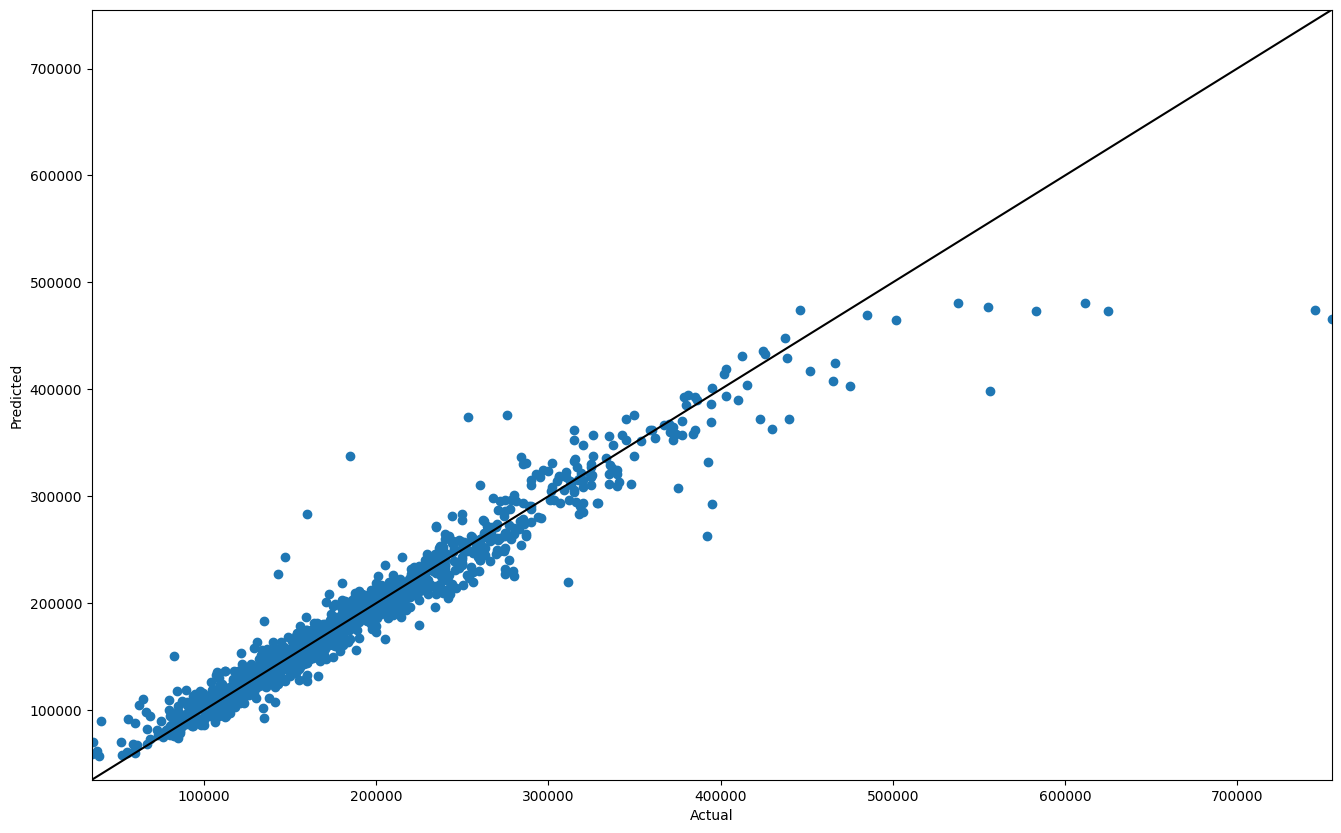

In [ ]:
plot_predictions(actual_price, gb_predictions)

In [ ]:
gb_rmse = rmse_cv(gb_model, 5)

In [ ]:
print(gb_rmse)

[0.13576101 0.10943298 0.15864117 0.12663196 0.11304526]


**RidgeRegression**

In [ ]:
from sklearn.linear_model import Ridge

In [ ]:
ridge_params = {'alpha': uniform(0, 1)}


ridge_randomSearch_model = Ridge()
ridge_randomSearch = RandomizedSearchCV(ridge_randomSearch_model, ridge_params, n_iter = 50, cv=5,
                              scoring='neg_mean_squared_error', random_state=42, refit=True)
ridge_randomSearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=Ridge(), n_iter=50,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bb48a9a7be0>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
ridge_randomSearch.best_params_

{'alpha': 0.9699098521619943}

In [ ]:
ridge_model = ridge_randomSearch.best_estimator_

In [ ]:
r2_score_3 = r2_cv(ridge_model , 5).mean()

In [ ]:
print(r2_score_3)

0.8804540430995746


In [ ]:
ridge_pred = ridge_model.predict(train_data_set)
ridge_predictions = np.exp(ridge_pred)

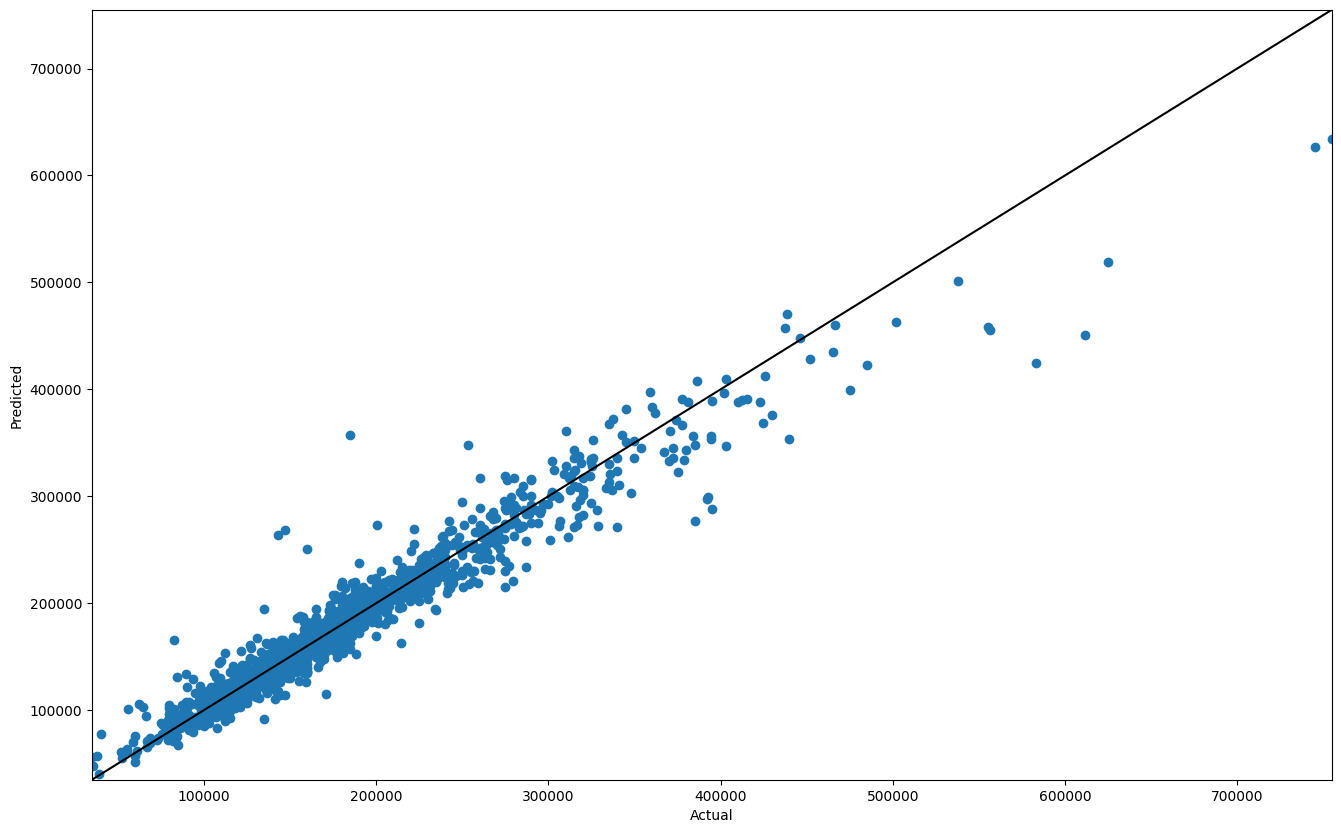

In [ ]:
plot_predictions(actual_price, ridge_predictions)

In [ ]:
ridge_rmse = rmse_cv(ridge_model, 5)

In [ ]:
print(ridge_rmse)

[0.1276046  0.12203283 0.18019082 0.12607688 0.11309178]


**Stack model**

In [ ]:
from lightgbm import LGBMRegressor
from sklearn.ensemble import StackingRegressor

In [ ]:
warnings.filterwarnings("ignore", category=UserWarning, module="lightgbm")

In [ ]:
base_model = [('XGBoost', xgb_model), ('GradientBoosting', gb_model), ('Ridge', ridge_model)]

light_params = {
    'final_estimator__subsample': uniform(0.5, 0.5),
    'final_estimator__reg_alpha': [0, 1e-5, 1e-2, 0.1, 1, 100]
}


stack_randomSearch_model = StackingRegressor(estimators = base_model, final_estimator = LGBMRegressor(verbose = -1))

stack_randomSearch = RandomizedSearchCV(stack_randomSearch_model, light_params,n_iter = 10, cv=5,
                              scoring='neg_mean_squared_error', random_state=42, refit=True)

stack_randomSearch.fit(X_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=StackingRegressor(estimators=[('XGBoost',
                                                            XGBRegressor(base_score=None,
                                                                         booster=None,
                                                                         callbacks=None,
                                                                         colsample_bylevel=None,
                                                                         colsample_bynode=None,
                                                                         colsample_bytree=0.6523068845866853,
                                                                         device=None,
                                                                         early_stopping_rounds=None,
                                                                         enable_categorical=False,
                                                                         eval_metric=None,
                                                                         feature_types=None,
                                                                         gamma=None,
                                                                         grow_policy=None,
                                                                         importanc...
                                                                                      subsample=0.5453032172664104)),
                                                           ('Ridge',
                                                            Ridge(alpha=0.9699098521619943))],
                                               final_estimator=LGBMRegressor(verbose=-1)),
                   param_distributions={'final_estimator__reg_alpha': [0, 1e-05,
                                                                       0.01,
                                                                       0.1, 1,
                                                                       100],
                                        'final_estimator__subsample': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7bb48bf8a200>},
                   random_state=42, scoring='neg_mean_squared_error')

In [ ]:
stack_model = stack_randomSearch.best_estimator_

In [ ]:
stack_randomSearch.best_params_

{'final_estimator__reg_alpha': 1,
 'final_estimator__subsample': 0.5780093202212182}

In [ ]:
r2_score_4 = r2_cv(stack_model, 5)

In [ ]:
print(r2_score_4.mean())

0.9032337139817367


In [ ]:
stack_pred = stack_model.predict(train_data_set)
stack_predictions = np.exp(stack_pred)

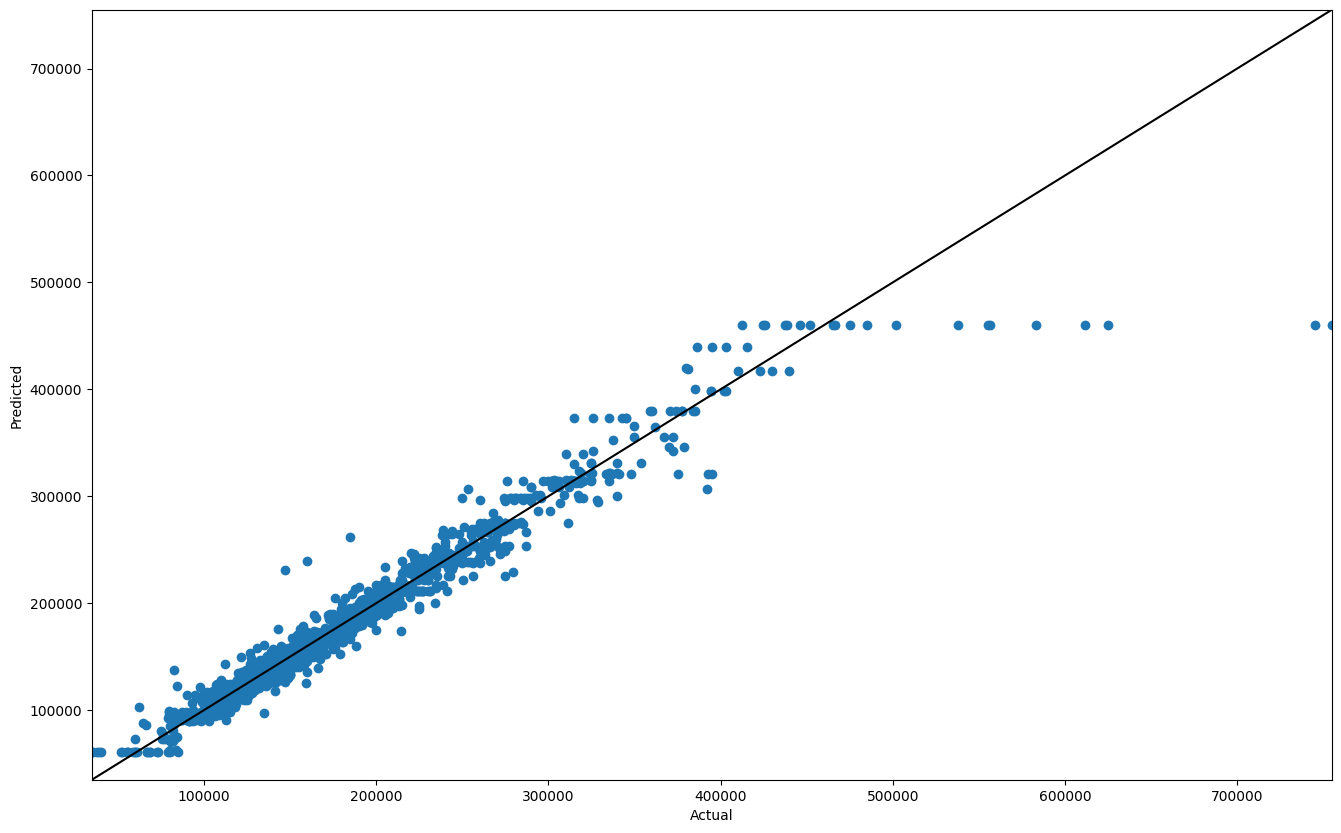

In [ ]:
plot_predictions(actual_price, stack_predictions)

In [ ]:
final_stack_model = stack_model.fit(X, y)

In [ ]:
final_pred = final_stack_model.predict(train_data_set)
final_predictions = np.exp(final_pred)

In [ ]:
print(final_predictions[:6])

[208308.42479578 182891.52421297 211894.17788924 150908.60613886
 271534.74939123 154256.23708658]


# **Submission**

In [ ]:
sub_pred = final_stack_model.predict(test_data_set)
sub_predictions = np.exp(sub_pred)

In [ ]:
test_data_sub = pd.read_csv('/content/house-prices-advanced-regression-techniques/test.csv')

In [ ]:
sub_df = pd.DataFrame()
sub_df['Id'] = test_data_sub.Id
sub_df['SalePrice'] = sub_predictions
sub_df.head(3)

,Id,SalePrice
0,1461,120520.930798
1,1462,163605.502384
2,1463,187663.333103


In [ ]:
sub_df.to_csv('House_predition_submission.csv', index=False)